## Prepare your environment

As always, we highly recommend that you use colab, or install all packages with a virtual environment manager, like [venv](https://packaging.python.org/en/latest/guides/installing-using-pip-and-virtual-environments/) or [conda](https://docs.conda.io/projects/conda/en/latest/user-guide/getting-started.html), to prevent version conflicts of different packages.  

### Install and load packages

In [1]:
from datasets import load_dataset
import torch
import jsonlines
from tqdm import tqdm
import os
import pandas as pd
import numpy as np

/home/xu0494akk/miniconda3/envs/py36/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("test.txt","r", errors='ignore') as f:
  text_list = []
  for sentence in f.readlines():
    text_list.append(sentence)

with open("reference.txt","r",  errors='ignore') as f:
  ref_list = []
  for sentence in f.readlines():
    ref_list.append(sentence)


print(len(text_list))
print(len(ref_list))

4384
4384


## The dataset
We are using the W&I+LOCNESS dataset to finetune T5(-small). 

The W&I+LOCNESS dataset is made up of entries from 
- Write & Improve (Yannakoudakis et al., 2018), an online web platform that assists non-native English students with their writing, and 
- the LOCNESS corpus (Granger, 1998), which consists of essays written by native English students.

([Details here](https://www.cl.cam.ac.uk/research/nl/bea2019st/) under the title "Data")

In [4]:
data_files = {'train': os.path.join('csv_file', 'train.csv'),\
              'validation': os.path.join('csv_file', 'dev.csv'),\
              'test': os.path.join('csv_file', 'test.csv')}
dataset = load_dataset('csv', data_files = data_files)

Using custom data configuration default-3e603f4e89ea60ba
Reusing dataset csv (/home/xu0494akk/.cache/huggingface/datasets/csv/default-3e603f4e89ea60ba/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
100%|██████████| 3/3 [00:00<00:00, 692.36it/s]


In [5]:
# have a look!
print(len(dataset['train']['text']))
print(dataset['train'][0])
print(dataset['test'][0])

13778
{'text': 'Besides,I find those talking about building massive structures and science interesting and I learnt some knowledge from those programs.', 'corrected': 'Besides, I find those programs talking about building massive structures and science interesting'}
{'text': 'It \'s difficult answer at the question " what are you going to do in the future ? " if the only one who has to know it is in two minds .\n', 'corrected': 'It \'s difficult to answer the question " what are you going to do in the future ? " if the only one who has to know it is in two minds .\n'}


## Pre-processing

### Tokenizater
Like our previous assignment on sentence classification, we need a tokenizer. This time, we're using T5's tokenizer.

- [Tokenizer base class documentation](https://huggingface.co/docs/transformers/v4.24.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer) just FYI

In [6]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

In [7]:
MODEL_NAME = 't5-small'
MODEL_MAX_LEN = 256

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    model_max_length=MODEL_MAX_LEN
    )

**[ TODO ]:** tokenize the input and output sequences. 

In [11]:
# batch-tokenize inputs 
def tokenize_batch(batch):
    """ Input: a batch of your dataset
        Example: { 'text': [['sentence1'], ['setence2'], ...],
                   'corrected': ['correct_sentence1', 'correct_sentence2', ...] }
    """
    
    # encode the source sentence, i.e. the grammatically-incorrect sentences
    input_sequences = batch['text']
    input_encoding = tokenizer(
        input_sequences, padding='max_length', max_length=MODEL_MAX_LEN, truncation=True, return_tensors="pt"
    )

    input_ids, attention_mask = input_encoding.input_ids, \
                                input_encoding.attention_mask

    # encode the targets, i.e. the corrected sentences
    output_sequences = batch['corrected']
    target_encoding = tokenizer(
        output_sequences, padding='max_length', max_length=MODEL_MAX_LEN, truncation=True, return_tensors="pt"
    )
    labels = target_encoding.input_ids # we only need the token ids of the target sequences during training

    # replace padding token id's of the labels by -100 so it's ignored by the loss
    labels[labels == tokenizer.pad_token_id] = -100
    
    ################################################

    """ Output: a batch of processed dataset
        Example: { 'input_ids': ...,
                   'attention_masks': ...,
                   'label': ... }
    """
    return {"input_ids": input_ids, "attention_mask": attention_mask, "label": labels}
    #loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss

If you look up online tutorials of finetuning T5, you might see that a prefix is added before each sequence before encoding it in the step above. This is done because T5 was originally trained as a multi-task model. Adding a prefix is a way to let the model know which task it should perform with a given text during inference. 

We don't have to do that here**, because we are only finetuning T5 on a single task, i.e. GEC.


For more information, please refer to this [tutorial](https://huggingface.co/docs/transformers/model_doc/t5#training)



*** TA's note: In fact, appending a `gec:` prefix to the input sentences during training only worsen the model performance. 
I learned this the hard way...* 💔 

### Batch-tokenization

In [12]:
# map the function to the whole dataset
train_val_dataset = dataset.map(tokenize_batch,    # your processing function
                                batched = True # Process in batches so it can be faster
                                )
#train_val_dataset["train"] = train_val_dataset["train"].remove_columns(["text","corrected"])
#train_val_dataset["validation"] = train_val_dataset["validation"].remove_columns(["text","corrected"])
#train_val_dataset["test"] = train_val_dataset["test"].remove_columns(["text","corrected"])

print(train_val_dataset)

100%|██████████| 14/14 [00:04<00:00,  2.99ba/s]
Loading cached processed dataset at /home/xu0494akk/.cache/huggingface/datasets/csv/default-3e603f4e89ea60ba/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-8972de8e0f218fcd.arrow
Loading cached processed dataset at /home/xu0494akk/.cache/huggingface/datasets/csv/default-3e603f4e89ea60ba/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-f2fda0db860c1fa6.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'corrected', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 13778
    })
    validation: Dataset({
        features: ['text', 'corrected', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1723
    })
    test: Dataset({
        features: ['text', 'corrected', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 4384
    })
})


## Training

### Setup training parameters

As before, we use the Trainer API to do the training. You may use the default hyperparameters that the TA has set for you.

Document:
- [transformers.Seq2SeqTrainingArguments](https://huggingface.co/docs/transformers/master/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments)
- [transformers.Seq2SeqTrainer](https://huggingface.co/docs/transformers/master/en/main_classes/trainer#transformers.Seq2SeqTrainer)

In [13]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [14]:
### Select GPU(s) for backend
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [15]:
import torch
# Check if any GPU is used
torch.cuda.is_available()

True

In [23]:
from transformers import T5ForConditionalGeneration
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)

OUTPUT_DIR = './model'
LEARNING_RATE = 2e-4
BATCH_SIZE = 32
EPOCH = 5
training_args = Seq2SeqTrainingArguments(
    output_dir = OUTPUT_DIR,
    learning_rate = LEARNING_RATE,
    per_device_train_batch_size = BATCH_SIZE,
    per_device_eval_batch_size = BATCH_SIZE,
    num_train_epochs = EPOCH,
    # you can set more parameters here if you want
)

# now give all the information to a trainer
trainer = Seq2SeqTrainer(
    # set your parameters here
    model = model,
    args = training_args,
    train_dataset = train_val_dataset["train"],
    eval_dataset = train_val_dataset["validation"],
    tokenizer = tokenizer,
)

loading configuration file https://huggingface.co/t5-small/resolve/main/config.json from cache at /home/xu0494akk/.cache/huggingface/transformers/fe501e8fd6425b8ec93df37767fcce78ce626e34cc5edc859c662350cf712e41.d67b370cd9d75f81ad4eb421ee7b8db09e0b6a6c693b8c2b423af5d7bcac6205
Model config T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
    

### Train 🚀

This is the easy part. Simply ask the trainer to train the model for you!

In [24]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: corrected, text. If corrected, text are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 13778
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2155


Step,Training Loss
500,0.507900
1000,0.422700
1500,0.387200
2000,0.370800


Saving model checkpoint to ./model/checkpoint-500
Configuration saved in ./model/checkpoint-500/config.json
Model weights saved in ./model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./model/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./model/checkpoint-500/special_tokens_map.json
Copy vocab file to ./model/checkpoint-500/spiece.model
Saving model checkpoint to ./model/checkpoint-1000
Configuration saved in ./model/checkpoint-1000/config.json
Model weights saved in ./model/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./model/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./model/checkpoint-1000/special_tokens_map.json
Copy vocab file to ./model/checkpoint-1000/spiece.model
Saving model checkpoint to ./model/checkpoint-1500
Configuration saved in ./model/checkpoint-1500/config.json
Model weights saved in ./model/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./model/checkpoint-1500/tokeni

TrainOutput(global_step=2155, training_loss=0.41684052717381453, metrics={'train_runtime': 781.4722, 'train_samples_per_second': 88.154, 'train_steps_per_second': 2.758, 'total_flos': 4661848351703040.0, 'train_loss': 0.41684052717381453, 'epoch': 5.0})

### Save for loading during demo

**[ TODO ]:** save your model for future use and load it during demo

We will ask you to perform inference with your model during demo!

In [25]:
# [ TODO ] save your model for future use
model.save_pretrained("saving_pretrained_model")

Configuration saved in saving_pretrained_model/config.json
Model weights saved in saving_pretrained_model/pytorch_model.bin


## Prediction
Inference is a bit different for a seq2seq model compared to a classification model. 

The model has to first generate the sequence from the given input sequence. How the sequence is generated differ based on the model. You may read more about it [here](https://huggingface.co/blog/encoder-decoder).

Since the generated sequences are represented as vectors / embeddings, we need to *decode* the model output with the tokenizer.

In [26]:
# just to make sure you're using a GPU
cur_device = torch.cuda.current_device()
device = torch.device(cur_device)
print(cur_device)

0


In [27]:
### Load finetuned model

model = T5ForConditionalGeneration.from_pretrained("saving_pretrained_model")
model.to(device)

loading configuration file saving_pretrained_model/config.json
Model config T5Config {
  "_name_or_path": "t5-small",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "nu

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

### Get the prediction

Here are a few example sentences:

In [28]:

sentences = ["The houses was wonderful.", "I like to working in NYC.", "She is involve in accident.", ]

inputs = tokenizer(sentences, return_tensors="pt", padding=True)
inputs.to(device)

output_sequences = model.generate(
    input_ids=inputs["input_ids"],
    attention_mask=inputs["attention_mask"],
    do_sample=False,
)

print(tokenizer.batch_decode(output_sequences, skip_special_tokens=True))

['The houses were wonderful.', 'I like working in NYC.', 'She is involved in an accident.']


### Predict on the W&I+LOCNESS "test" set

#### **A note on the "test" set**
The "test" set here is not really the official test set, since the latter is witheld by the dataset provider to ensure fairness among all competitors for SOTA. 
Instead, the validation set you just used during training is split from the training set, and you'll be evaluating the model on the original validation set.



**[ TO DO ]:** use the model you just trained to turn the grammatically-incorrect test-set sentences into corrected sentences. This involves **loading** the test set, using the model to **generate** the numerically-represented transformed sentences (in tensor form), and **decoding** the generated tensors. 

You may reference the [🤗 documentation](https://huggingface.co/docs/transformers/model_doc/t5#inference) for what to put in the methods.



[Optional] (you may do this just for the science; no bonus points will be given for this.) 

Store the output in the input `dataset` data structure to make life easier if you choose to iterate the output multiple times through the model (see next step for details). Otherwise, save it in any format you find convenient :)


In [29]:
# load the test data
test_data = train_val_dataset["test"]
print(test_data)

Dataset({
    features: ['text', 'corrected', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 4384
})


In [30]:
# Implement the functin to generate and batch decoode the generated sequence
# batch-tokenize and then decode inputs 
@torch.no_grad()
def decode_batch(batch):
    """ Input: a batch of an **untokenized** dataset
        Example: { 'text': ['sentence1', 'setence2', ...],
                   'corrected': ['correct_sentence1', 'correct_sentence2', ...] }
    """
    output = tokenizer(
      batch["text"], return_tensors="pt", max_length=512, truncation=True, padding='max_length',)  # Batch size 1
    input_ids = output.input_ids.to("cuda")
    attention_mask = output.attention_mask.to("cuda")
    
    
    output_sequences = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=512,        
        num_beams=2,
        early_stopping=False
    )
    
    decoded = tokenizer.decode(
       output_sequences[0],
       skip_special_tokens=True,
       clean_up_tokenization_spaces=True
       )
    batch["decoded"] = decoded
    return batch

In [31]:
# adjust the arguments as you need
decoded = test_data.map(
    decode_batch,    # your processing function
    batched = False,  # Process in batches so it can be faster
    batch_size=50
    )
print(decoded)

Parameter 'function'=<function decode_batch at 0x7f64bc17e730> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
100%|██████████| 4384/4384 [12:10<00:00,  6.00ex/s]


Dataset({
    features: ['text', 'corrected', 'input_ids', 'attention_mask', 'labels', 'decoded'],
    num_rows: 4384
})


In [48]:
assert len(decoded["decoded"])==len(decoded["text"])
print(decoded["text"][0])
print(decoded["decoded"][0])

It 's difficult answer at the question " what are you going to do in the future ? " if the only one who has to know it is in two minds .

It's a difficult answer at the question " what are you going to do in the future? " if the only one who has to know it is in two minds.


[ Optional ] (no bonus points for this)

Since some corrections in a sentence may depend on previous corrections, applying GEC sequence tagger only once may not be enough to fully correct the sentence. Thus, many methods suggest running the generated output of a GEC model through the system more than once. Try this on the test data!

In [ ]:
iterations = 3
pred_iter = [decoded] # you may want to save the output of each iteration

for i in range(iterations):
    ...

[ Optional ] (no bonus points) Write a script to view the differences between each iteration, and view the results to decide which iteration you want to evaluate on. 

In [ ]:
diffs = []
for idx, it in enumerate(pred_iter):
    i = 0
    print(f"ITERATION {idx}")
    for txt_idx, text in enumerate(it['text']):
        ...
    print(f"NUM CORRECTED SENTENCES: {i}")

## Evaluation
#### ERRANT
One evaluation metric for GEC is the ERRANT (see details under the title [Evaluation](https://www.cl.cam.ac.uk/research/nl/bea2019st/)), an improved version of the [MaxMatch scorer](https://github.com/nusnlp/m2scorer), where precision and recall are based on span and token match.

The metric ERRANT uses is [F0.5](https://en.wikipedia.org/wiki/F-score#F%CE%B2_score), where precision is weighted twice the recall.

We use [the ERRANT toolkit](https://github.com/chrisjbryant/errant) to evaluate our output. 

== a couple of terms ==
- Sources = the sentences to be corrected
- Hypotheses = the sentences we predicted, hopefully grammatically correct
- References = the gold-standard sentences (i.e. sentences grammatically corrected by human annotators; the "answer")


`errant_parallel` converts the span-based difference between the **sources** and the **hypotheses** into a `.m2` file.

```
S It 's difficult answer at the question " what are you going to do in the future ? " if the only one who has to know it is in two minds .
A 3 3|||M:VERB:FORM|||to|||REQUIRED|||-NONE-|||0
A 4 5|||U:PREP||||||REQUIRED|||-NONE-|||0
```

Next, `errant_compare` compares the above `.m2` file against the `.m2` file of a **reference** and the **source**, and calculates the F0.5 score. 

If you feel like you need to draw a graph to understanding this more clearly, it's okay. The TA did too.

**[ TO DO ]** Use the ERRANT scorer to evaluate the test set and show the results
...you don't really need to do anything here. Just run the code (perhaps change the outptu file name) and show the results during demo.

In [33]:
!mkdir -p "OUTPATH/OUTNAME.out" # change the output file path and name as you wish

In [34]:
with open("OUTPATH/output.csv", "w",errors='ignore') as f:
    for line in decoded['decoded']:
        f.write(line+"\n")

In [35]:
# this will take about 1 minute
!errant_parallel -ori test.txt -cor OUTPATH/output.csv -out OUTPATH/out.m2

Loading resources...
Processing parallel files...


In [36]:
!errant_compare -ref bea-full-valid.m2 -hyp OUTPATH/out.m2


=========== Span-Based Correction ============
TP	FP	FN	Prec	Rec	F0.5
1066	10248	6395	0.0942	0.1429	0.1011



You may notice that the scores are quite low. This is fine. (The TA got only ~0.1 F0.5 😅)

This (finetuning T5 by feeding it parallel text) is only one of the [many methods](https://nlpprogress.com/english/grammatical_error_correction.html) developed in attempt to solve GEC. Other contributing factors for this include:
- this T5 is tiny (60m parameters) compared to other T5s (e.g. T5-base: 220m, T5-large: 770m);
- the training data is quite small. Studies usually combine many other datasets, such as Lang-8 (947k sentences), FEC (34k sentences), and perform data augmentation.

**What other factors can you think of that contribute to the low performance?**

**[ TO DO (Optional, with bonus points) ]:** Think of one factor that might affect the model performance, and 

(a) come up with 1 way to verify that via experimentation (you don't need to actually do the experiment), OR 

(b) find 1 paper to prove your hypothesis. We will ask you to show the paper and point out the part where it proves your hypothesis.

----------
**[ TO DO ]** Plot a histogram of the `.m2` file you generated.

You now have the gold standard `.m2` file and the `.m2` file from the corrections you generated from T5. 

In the `.m2` files, lines containing items seperated by 3 pipes (|||) are the correction types (and spans for their corresponding words or phrases) generated by comparing the sentences from the source file and the source/hypotheses file. 

For example, for `A 3 3|||M:VERB:FORM|||to|||REQUIRED|||-NONE-|||0`, `M:VERB:FORM` is the correction type.

Below is a bar plot (histogram) of the correction types from the gold-standard `.m2` file (i.e.`bea-full-valid.m2`). Plot **a histogram/bar plot for the top-10 correction types** of the `.m2` file generated by **the source and the hypothesis**. How are the top-10 corrections different from the gold-standard ones?
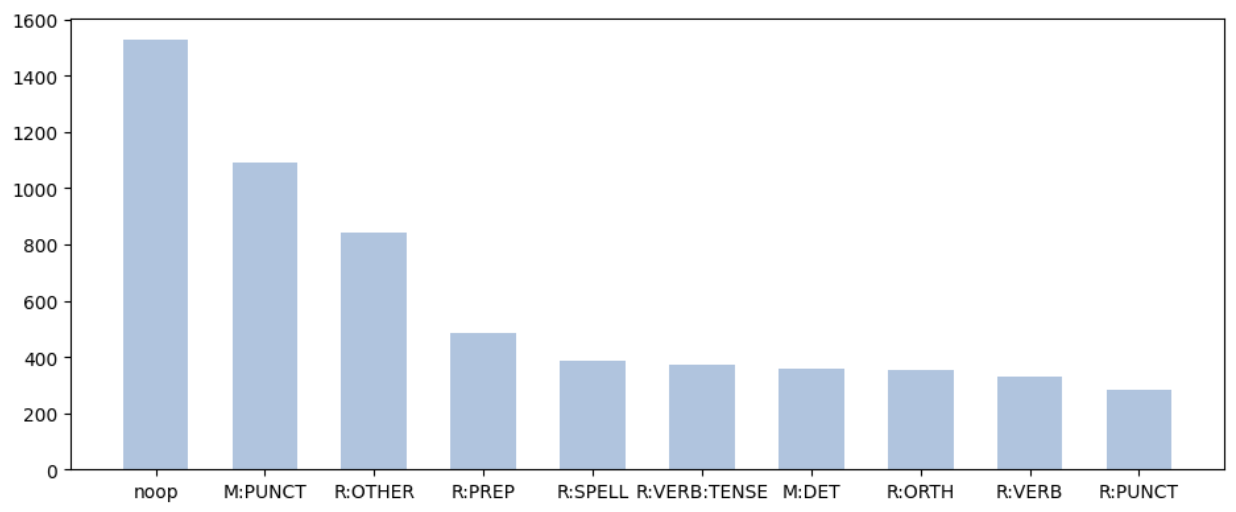

In [37]:
def find_correct_type(line):
  count_mark=0
  result = ""
  for i in line:
    if i == "|":
      count_mark += 1
      if count_mark == 4:
        break  
    else:
      if count_mark >= 3:
        result+=i
  return result
    

['R:ORTH', 'R:OTHER', 'R:NOUN', 'M:DET', 'R:PREP', 'U:PUNCT', 'U:DET', 'R:SPELL', 'R:VERB:SVA', 'R:VERB:FORM']
[7951, 750, 389, 236, 187, 181, 174, 162, 157, 138]


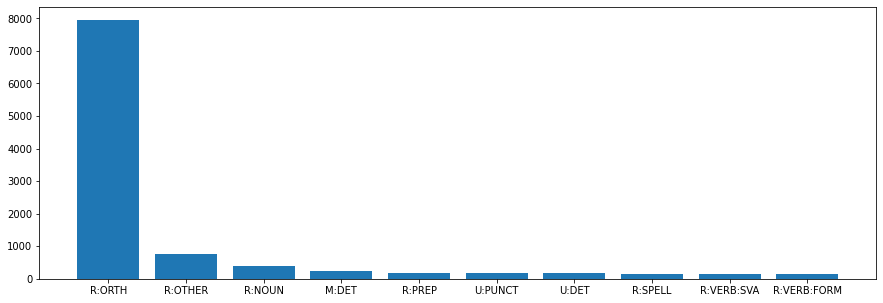

In [38]:
import matplotlib.pyplot as plt
import collections

with open("OUTPATH/out.m2","r",errors="ignore") as f:
  correct_type_list = []
  for index,line in enumerate(f.readlines()):
    if line[0] == "A":
      correct_type_list.append(find_correct_type(line))
counter = collections.Counter(correct_type_list)
result = counter.most_common(10)
x=[i[0] for i in result]
y=[i[1] for i in result]
print(x)
print(y)
plt.figure(figsize=(15,5))
plt.bar(x,y)
plt.show()

### Evaluation: Your turn
You have two main tasks:
1. **[TO DO]** Evaluate the model we just trained with ERRANT on another dataset: [JFLEG](https://github.com/keisks/jfleg). (Do you get a higher or lower score? Explain.)
2. **[TO DO]** GLEU is another metric, originally developed to evaluate machine translation, that is used to evaluate GEC. Use GLEU to evaluate your model on **both** W&I+LOCNESS and JFLEG. 

You may reference [this](https://www.nltk.org/api/nltk.translate.gleu_score.html) or [this](https://github.com/keisks/jfleg/blob/master/eval/gleu.py) to calculate the GLEU scores. 

### Evaluate on JFLEG with ERRANT
Note: For JFLEG, you need to generate your own gold-standard `.m2` file. Use `errant_parallel` like you did for generating the source-hypothesis `.m2` file.

JFLEG provides multiple reference files. For simplicity, just use `dev.ref0` as the reference file.

In [39]:
jf_test_data = load_dataset(
    # load the jfleg dev set
    "jfleg/dev"
    )
print(jf_test_data["validation"][:10])


Using custom data configuration dev-6474306b1e472c93


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 706.94it/s]


Dataset text downloaded and prepared to /home/xu0494akk/.cache/huggingface/datasets/text/dev-6474306b1e472c93/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 440.39it/s]

{'text': ['So I think we can not live if old people could not find siences and tecnologies and they did not developped . ', 'For not use car . ', 'Here was no promise of morning except that we looked up through the trees we saw how low the forest had swung . ', 'Thus even today sex is considered as the least important topic in many parts of India . ', 'image you salf you are wark in factory just to do one thing like pot taire on car if they fire you you will destroy , becouse u dont know more than pot taire in car . ', 'They draw the consumers , like me , to purchase this great product with all these amazing ingredients and all that but actually they just sometimes make something up just to increase their sales . ', 'I want to talk about nocive or bad products like alcohol , hair spray and cigarrets . ', 'For example they can play football whenever they want but the olders can not . ', 'It figures Diana Krall wearing a Rolex watch and has a text that suggests that if the reader wants t

In [40]:
print(jf_test_data)

DatasetDict({
    validation: Dataset({
        features: ['text'],
        num_rows: 754
    })
})


In [41]:
jf_decoded = jf_test_data.map(
    decode_batch
    )

100%|██████████| 754/754 [01:59<00:00,  6.32ex/s]


In [42]:
print(jf_decoded["validation"]["text"][:10])
print(jf_decoded["validation"]["decoded"][:10])

['So I think we can not live if old people could not find siences and tecnologies and they did not developped . ', 'For not use car . ', 'Here was no promise of morning except that we looked up through the trees we saw how low the forest had swung . ', 'Thus even today sex is considered as the least important topic in many parts of India . ', 'image you salf you are wark in factory just to do one thing like pot taire on car if they fire you you will destroy , becouse u dont know more than pot taire in car . ', 'They draw the consumers , like me , to purchase this great product with all these amazing ingredients and all that but actually they just sometimes make something up just to increase their sales . ', 'I want to talk about nocive or bad products like alcohol , hair spray and cigarrets . ', 'For example they can play football whenever they want but the olders can not . ', 'It figures Diana Krall wearing a Rolex watch and has a text that suggests that if the reader wants to belong 

In [43]:
# write to file for evaluation

with open("jfleg/OUTPATH/output.csv", "w") as f:
    for line in jf_decoded["validation"]['decoded']:
        f.write(line+"\n")

In [44]:
# ERRANT-evaluate JFLEG
!errant_parallel -ori jfleg/dev/dev.txt -cor jfleg/OUTPATH/output.csv -out jfleg/OUTPATH/out.m2
!errant_parallel -ori jfleg/dev/dev.txt -cor jfleg/dev/reference.txt -out jfleg/OUTPATH/ref0.m2
!errant_compare -ref jfleg/OUTPATH/ref0.m2 -hyp jfleg/OUTPATH/out.m2

Loading resources...
Processing parallel files...
Loading resources...
Processing parallel files...

=========== Span-Based Correction ============
TP	FP	FN	Prec	Rec	F0.5
368	1932	2332	0.16	0.1363	0.1546



In [45]:
with open("jfleg/dev/reference.txt","r") as f:
  ref_list = []
  for i in f.readlines():
    ref_list.append(i)
len(ref_list)

754

### GLEU evaluation for WI+LOC and JFLEG
Note: the GLEU calculator may offter sentence-based GLEU scores and the mean GLEU score. You only need to obtain the mean GLEU score for each dataset.

In [46]:
from nltk.translate.gleu_score import sentence_gleu

In [47]:
wi_hyp = decoded["decoded"]
wi_ref = decoded["corrected"]
jf_hyp = jf_decoded["validation"]["decoded"]
jf_ref = ref_list

sum_of_wi_score = 0
for row in range(len(wi_ref)):
  sum_of_wi_score += sentence_gleu(wi_ref[row].split(),wi_hyp[row].split())    
avg_wi_score = sum_of_wi_score/len(wi_ref)
print("average wi+loc glue: ",avg_wi_score)

sum_of_jf_score = 0
for row in range(len(jf_ref)):
  sum_of_jf_score += sentence_gleu(jf_ref[row].split(),jf_hyp[row].split())    
avg_jf_score = sum_of_jf_score/len(jf_ref)
print("average jfleg glue: ",avg_jf_score)


average wi+loc glue:  0.010032730635696244
average jfleg glue:  0.00785750921442563


**[ TO DO (Optional, with bonus points) ]** Is GLEU or ERRANT higher? Which of these is a better measure of grammaticity? Why?

## TA's Note

Phew, you made it to the end of the tutorial! Make sure you make an appointment to show your work and turn in your finished assignment before next week's lesson. Don't worry if you didn't pass the evaluation requirements, you'll still get partial points for trying. 

Grading:
- Optional TODOs are bonus points. 
- You will earn 90 points from completing the non-optional TODOs.